## Check GPU

In [158]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



## Download Data

In [159]:
!gdown --id '1vL5huCbpu9ue2Xt0wV9PKjrFfGP6p3Ay' --output train.csv
!gdown --id '17_ymt4mwN1FSGrR1EUTyOsPfX6k2pgjW' --output test.csv
!gdown --id '1TkTHU2NOaezsfIgN42-iAYf3Wf1TJ0r8' --output gender_submission.csv
!ls

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1vL5huCbpu9ue2Xt0wV9PKjrFfGP6p3Ay
To: /content/train.csv
100% 61.2k/61.2k [00:00<00:00, 66.2MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=17_ymt4mwN1FSGrR1EUTyOsPfX6k2pgjW
To: /content/test.csv
100% 28.6k/28.6k [00:00<00:00, 40.2MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://

## Import Package

In [160]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torch import nn
import random
import os
import torch
from tqdm.auto import tqdm
import seaborn as sns
from torch.nn import functional as F
from torch.autograd import Variable

## Read Data

In [161]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
ans_df = pd.read_csv("gender_submission.csv")

## Data Preprocess

In [162]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


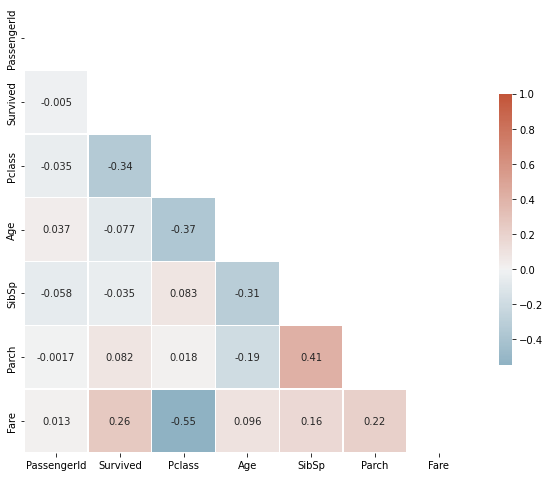

In [163]:
f, ax = plt.subplots(figsize=(10, 10))
mat = train_df.corr()
mask = np.triu(np.ones_like(mat, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(mat, mask=mask, cmap=cmap, vmax=1, center=0, annot = True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

In [164]:
ytrain = train_df.Survived
feature = train_df.append(test_df)
feature.drop(['PassengerId','Name', 'Ticket', 'Cabin','Survived'], inplace=True, axis=1)
feature['Embarked'].fillna(feature['Embarked'].value_counts().idxmax(), inplace=True)
feature['Fare'].fillna(feature['Fare'].mean(), inplace=True)
feature['Age'].fillna(feature['Age'].value_counts().idxmax(), inplace=True)
feature = pd.get_dummies(feature ,columns = ["Sex", "Embarked", "Pclass"], drop_first = True)

## Split data

In [165]:
trainNRows = train_df.shape[0]
train = feature.iloc[:trainNRows]
test = feature.iloc[trainNRows:]
print('training set', train.shape)
print('test set', test.shape)

training set (891, 9)
test set (418, 9)


In [166]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train, ytrain, test_size = 0.1, random_state = 852)

In [167]:
X_train.shape, y_train.shape,X_test.shape

((712, 9), (712,), (179, 9))

In [168]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(9, 256)
        self.fc2 = nn.Linear(256, 512)
        self.fc3 = nn.Linear(512, 2)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x))        
        x = F.leaky_relu(self.fc2(x))        
        x = self.fc3(x)
        return x
model = Net()
print(model)

Net(
  (fc1): Linear(in_features=9, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=2, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


In [169]:
SEED = 508

def random_seed(SEED):
    
    random.seed(SEED)
    os.environ['PYTHONHASHSEED'] = str(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True

random_seed(SEED)

In [175]:
model=Net()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
model.train()
EPOCHS = 500
batch_size = 64
batch_number = len(X_train) // batch_size
train_loss = 0
loss_min = 1
step = 0
for epoch in range(EPOCHS):
    running_loss = []
    total = 0
    correct = 0
    for i in range(batch_number):
        start = i * batch_size
        end   = start + batch_size
        x_var = Variable(torch.FloatTensor(X_train[start:end].values))
        y_var = Variable(torch.LongTensor(y_train[start:end].values))
        optimizer.zero_grad()
        output = model(x_var)
        loss = criterion(output,y_var)
        loss.backward()
        optimizer.step()

        values, labels = torch.max(output, 1)
        num_right   = np.sum(labels.data.numpy() == y_train[start:end])
        train_loss += loss.item()*batch_size
    train_loss = train_loss / len(X_train)
    if train_loss < loss_min:        
        loss_min = train_loss
    if train_loss > loss_min:        
        step += 1
        if step > 15:
            break
    else:
        step = 0
    print(f"Epoch: {epoch+1} \tTrain Loss: {train_loss:5f} \tTrain Accuracy: {num_right / len(y_train[start:end]):.5f}")

Epoch: 1 	Train Loss: 4.138719 	Train Accuracy: 0.64844
Epoch: 2 	Train Loss: 0.904155 	Train Accuracy: 0.50781
Epoch: 3 	Train Loss: 0.739407 	Train Accuracy: 0.61719
Epoch: 4 	Train Loss: 0.630983 	Train Accuracy: 0.67188
Epoch: 5 	Train Loss: 0.598906 	Train Accuracy: 0.67188
Epoch: 6 	Train Loss: 0.581155 	Train Accuracy: 0.67969
Epoch: 7 	Train Loss: 0.571465 	Train Accuracy: 0.67188
Epoch: 8 	Train Loss: 0.561933 	Train Accuracy: 0.66406
Epoch: 9 	Train Loss: 0.556472 	Train Accuracy: 0.67969
Epoch: 10 	Train Loss: 0.552326 	Train Accuracy: 0.67969
Epoch: 11 	Train Loss: 0.549110 	Train Accuracy: 0.67969
Epoch: 12 	Train Loss: 0.546729 	Train Accuracy: 0.66406
Epoch: 13 	Train Loss: 0.544560 	Train Accuracy: 0.67188
Epoch: 14 	Train Loss: 0.542956 	Train Accuracy: 0.67188
Epoch: 15 	Train Loss: 0.541359 	Train Accuracy: 0.65625
Epoch: 16 	Train Loss: 0.539905 	Train Accuracy: 0.66406
Epoch: 17 	Train Loss: 0.538732 	Train Accuracy: 0.67188
Epoch: 18 	Train Loss: 0.537658 	Train A

In [176]:
test_var = Variable(torch.FloatTensor(test.values), requires_grad=False) 
with torch.no_grad():
    test_result = model(test_var)
values, labels = torch.max(test_result, 1)
survived = labels.data.numpy()
survived

array([0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0,
       1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1,
       1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1,
       0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0,
       0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0,

In [177]:
submission = pd.DataFrame({'PassengerId': test_df['PassengerId'], 'Survived': survived})
submission.to_csv('submission.csv', index=False)